# GENTRL Guacamol Benchmark

In [ ]:
import pandas as pd
import gentrl
import torch
from torch.utils.data import DataLoader
from moses.utils import CharVocab
import matplotlib.pyplot as plt
import numpy as np

GENTRL was evaluated on how well it could generate molecules that maximized 27 score functions from the GuacaMol benchmarking suite [GuacaMol benchmarking suite](https://github.com/BenevolentAI/guacamol).

Two types of training the model were used: The first type trains one prior model on a dataset containing SMILES and six properties used in the QED function. This model was then trained using reinforcement learning on each of the 27 score functions.

The second type of training was to use a special prior model for each score function. In this case, the prior model was trained on SMILES and corresponding score from the score function. Each model is then trained using RL on their corresponding score function. Celecoxib similarity will be used as an example in this notebook, but there are 26 others used in a similar way.

### The data used in the first type:


In [2]:
pd.read_csv("./data/guacamol_qed_props.csv.gz").head()

,SMILES,MW,ALOGP,HBD,PSA,ROTB,AROM,ALERTS,HBA
0,CCC(C)(C)Br,0.077295,0.401615,0.000000,0.000000,0.011765,0.000000,0.1,0.000000
1,CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...,0.258688,0.394986,0.157895,0.261313,0.105882,0.142857,0.0,0.222222
2,Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1,0.205587,0.468231,0.105263,0.102545,0.035294,0.214286,0.1,0.148148
3,CC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1,0.198044,0.354599,0.052632,0.181779,0.023529,0.000000,0.0,0.296296
4,COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...,0.302464,0.500131,0.000000,0.188828,0.117647,0.142857,0.2,0.296296


### Example of data used in the second type of training:
In this case the data is SMILES string and their similarity to celecoxib:

In [3]:
pd.read_csv("./data/guacamol_celecoxib_similarity.csv.gz").head(5)

,SMILES,celecoxib_similarity
0,CCC(C)(C)Br,0.024390
1,CCCN(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=C...,0.160839
2,Oc1ccc(C2CC(c3ccccc3)=NN2C(=S)Nc2ccccc2)cc1,0.200000
3,CC1(C)OCC2OC3(C4OC(C)(C)OC4CO)OC(C)(C)OC3C2O1,0.007246
4,COC(=O)c1cc(C(=CCCCC(=O)SC)c2cc(Cl)c(OC)c(C(=O...,0.092105


### Code used for training the VAELP
The models was trained using the following settings (in this case the first type of training is used).

The models have been trained for 5, 10 and 20 epochs. The recreation loss seem to reach an optima at around 0.23. Training the models more than 10 epochs did not show an improvement for the results.

In [ ]:

save_path = "./saved_model_gentrl/"
dataset_path = "./data/guacamol_qed_props.csv.gz"
vocab = CharVocab.from_data(df['SMILES'])
torch.cuda.set_device(0)

enc = gentrl.RNNEncoder(vocab, latent_size=50)
dec = gentrl.DilConvDecoder(vocab, latent_input_size=50, split_len=100) # Split len increased
model = gentrl.GENTRL(enc, dec, 50 * [("c", 20)], [("c", 20)], beta=0.001)
model.cuda()
props = ["MW", "ALOGP", "HBD", "HBA", "PSA", "ROTB", "AROM", "ALERTS"]
source = {
    "path": dataset_path,
    "smiles": "SMILES",
    "prob": 1,
}
for prop in props:
    source[prop] = prop

md = gentrl.MolecularDataset(sources=[source], props=props)

train_loader = DataLoader(
    md, batch_size=128, shuffle=True, num_workers=1, drop_last=True
)
model.train_as_vaelp(train_loader, lr=1e-4, num_epochs=10, save_path=save_path)
model.save(save_path)

## Training Results
### With QED Props

Using TensorFlow backend.


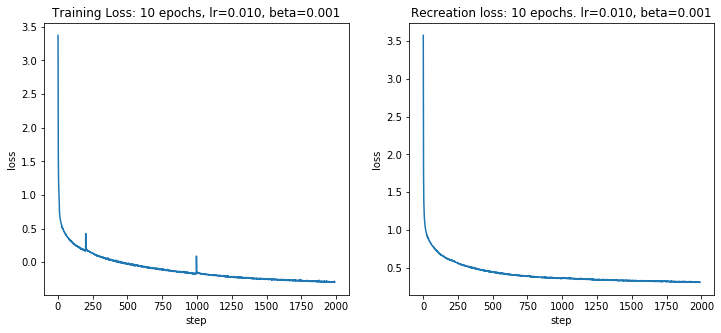

In [4]:
from utils import get_log_data, plot_log
loss_arr, rec_arr = get_log_data("./models/guacamol_chembl_qed_props/logs/guacamol_chembl_qed_props.log")
plot_log(loss_arr, rec_arr)

#### Final Loss:
* loss: -0.3003;
* rec: -0.3061;
* kl: -193.5;
* log_p_y_by_z: 4.129;
* log_p_z_by_y: -262.7;

### With only Celecoxib similarity prop

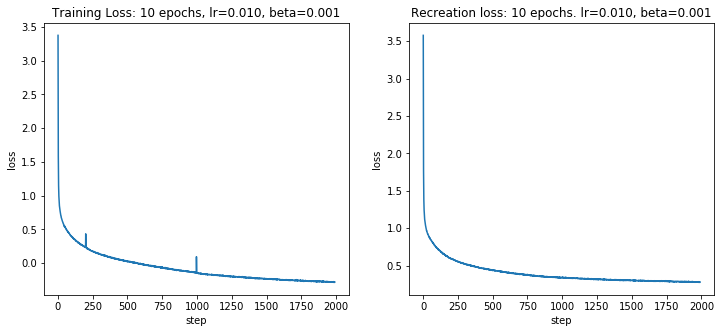

In [5]:
from utils import get_log_data, plot_log
loss_arr, rec_arr = get_log_data("./models/guacamol_only_celecoxib/logs/guacamol_only_celecoxib.log")
plot_log(loss_arr, rec_arr)



#### Final Loss:
* loss: -0.2831;
* rec: -0.2808;
* kl: -180.1;
* log_p_y_by_z: 3.837;
* log_p_z_by_y: -256.9;


## Reinforcement Learning
The following code was used to carry out reinforcement learning

In [ ]:
from utils import celecoxib_similarity
save_path_rl = "./models/guacamol_chembl_qed_props/rl"
pretrained_model_path = "./models/guacamol_chembl_qed_props"
model.load(pretrained_model_path)
model.cuda()

model.train_as_rl(
    celecoxib_similarity,
    num_iterations=10000,
    verbose_step=1,
    batch_size=512,
    lr_lp=1e-5,
    lr_dec=1e-6,
    sigma_multp=2,
    explore_ratio=0.3,
)

model.save(save_path)

## Results
The following are *the best* results from pre-training GENTRL and then running reinforcement learning.

Hyperparameters used for RL:
* Batch sizes: 50, 128, 512, 1000
* lr_lp: 1e-5, 1e-4, 1e-3, 1e-2
* lr_dec: 1e-7, 1e-6, 1e-5
* sigma_mult: 2, 3, ..., 10
* explore_ratio: 0.3, ..., 0.7
* num_iterations: 1000, 2000, 10000, 20000

The following are the best scores for these runs:

In [7]:
from IPython.display import HTML, display
import tabulate
results_gentrl = [["Celecoxib rediscovery", 0.439, 0.505], ["Troglitazone rediscovery", 0.261,0.419], ["Thiothixene rediscovery", 0.387, 0.456], ["Aripiprazole similarity", 0.38, 0.595], ["Albuterol similarity", 0.908, 0.719], ["Mestranol similarity", 0.542, 0.629], ["C11H24", 0.874, 0.684], ["C9H10N2O2PF2Cl", 0.835, 0.747], ["Median molecules 1", 0.346, 0.334], ["Median molecules 2", 0.166, 0.351], ["Osimertinib MPO", 0.797, 0.839], ["Fexofenadine MPO", 0.732, 0.817], ["Ranolazine MPO", 0.76, 0.792], ["Perindopril MPO", 0.452, 0.575], ["Amlodipine MPO", 0.573, 0.696], ["Sitagliptin MPO", 0.429, 0.509], ["Zaleplon MPO", 0.539, 0.547], ["Valsartan SMARTS", 0, 0.259], ["Scaffold Hop", 0.577, 0.738], ["Deco Hop", 0.452, 0.933], ["logP (target: -1.0)", 1, 1], ["logP (target: 8.0)", 1, 1], ["TPSA (target: 150.0)", 1, 1], ["CNS MPO", 1, 1],["QED", 0.939, 0.948], ["C7H8N2O2", 1, 0.972], ["Pioglitazone MPO", 0.887, 0.982]]

display(HTML(tabulate.tabulate(results_gentrl, tablefmt='html', headers=["GENTRL", "Dataset Max"])))

,GENTRL,Dataset Max
Celecoxib rediscovery,0.439,0.505
Troglitazone rediscovery,0.261,0.419
Thiothixene rediscovery,0.387,0.456
Aripiprazole similarity,0.38,0.595
Albuterol similarity,0.908,0.719
Mestranol similarity,0.542,0.629
C11H24,0.874,0.684
C9H10N2O2PF2Cl,0.835,0.747
Median molecules 1,0.346,0.334
Median molecules 2,0.166,0.351
